In [1]:
import os
import numpy as np
from matplotlib.pyplot import imread

In [2]:
path = 'Images/'
files = sorted([os.path.join(path, file) for file in os.listdir(path)])#[:300]
np.random.shuffle(files)

In [3]:
food = {food:i for i, food in enumerate(set([file.rsplit('_', 1)[0].rsplit('/', 1)[-1] for file in files]))}
food

{'apple': 2,
 'aubergine': 12,
 'avocado': 21,
 'banana': 6,
 'broccoli': 26,
 'butter': 11,
 'carrot': 5,
 'cherry': 22,
 'cucumber': 19,
 'durian': 9,
 'egg': 0,
 'fennel': 16,
 'fig': 10,
 'grape': 25,
 'kiwi': 4,
 'leek': 1,
 'lemon': 14,
 'mango': 20,
 'meat': 18,
 'melon': 17,
 'noodles': 13,
 'olive': 7,
 'pea': 15,
 'potato': 23,
 'raspberry': 24,
 'rice': 8,
 'strawberry': 3,
 'zucchini': 27}

In [4]:
label = np.eye(len(food))

In [5]:
images_1 = np.array([imread(file) for file in files])
images_2 = np.array([np.fliplr(imread(file)) for file in files])
images = np.concatenate([images_1, images_2])

In [6]:
n_label = np.array([food[file.rsplit('_', 1)[0].rsplit('/', 1)[-1]] for file in files])
n_label = np.array([label[food[file.rsplit('_', 1)[0].rsplit('/', 1)[-1]]] for file in files])
n_label = np.concatenate([n_label, n_label])

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, n_label, test_size=0.2)

In [8]:
del n_label, images_1, images_2, images

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Activation
from keras.optimizers import Adadelta
from keras.losses import categorical_crossentropy

Using TensorFlow backend.


In [10]:
model = Sequential()
model.add(Conv2D(10, kernel_size=(5, 5),
                 use_bias=False,
                 input_shape=(100, 150, 3,)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Conv2D(20, (5,5)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Conv2D(40, (5,5)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(len(food), activation='softmax'))

model.compile(loss=categorical_crossentropy,
              optimizer=Adadelta(),
              metrics=['accuracy'])

In [11]:
model.output_shape
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 146, 10)       750       
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 146, 10)       40        
_________________________________________________________________
activation_1 (Activation)    (None, 96, 146, 10)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 48, 10)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 44, 20)        5020      
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 44, 20)        80        
_________________________________________________________________
activation_2 (Activation)    (None, 28, 44, 20)        0         
__________

In [12]:
model.fit(X_train, y_train,
          batch_size=100,
          epochs=2,
          verbose=1,
          validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

model.save_weights('Keras_Food_Model.h5')

Train on 4480 samples, validate on 1120 samples
Epoch 1/2
4480/4480 [==============================] - 547s - loss: 3.6950 - acc: 0.0400 - val_loss: 3.2945 - val_acc: 0.0562
Epoch 2/2
4480/4480 [==============================] - 568s - loss: 3.3302 - acc: 0.0629 - val_loss: 3.2001 - val_acc: 0.1259
Test loss: 3.20006905964
Test accuracy: 0.125892857143


49/49 [==============================] - 3s     


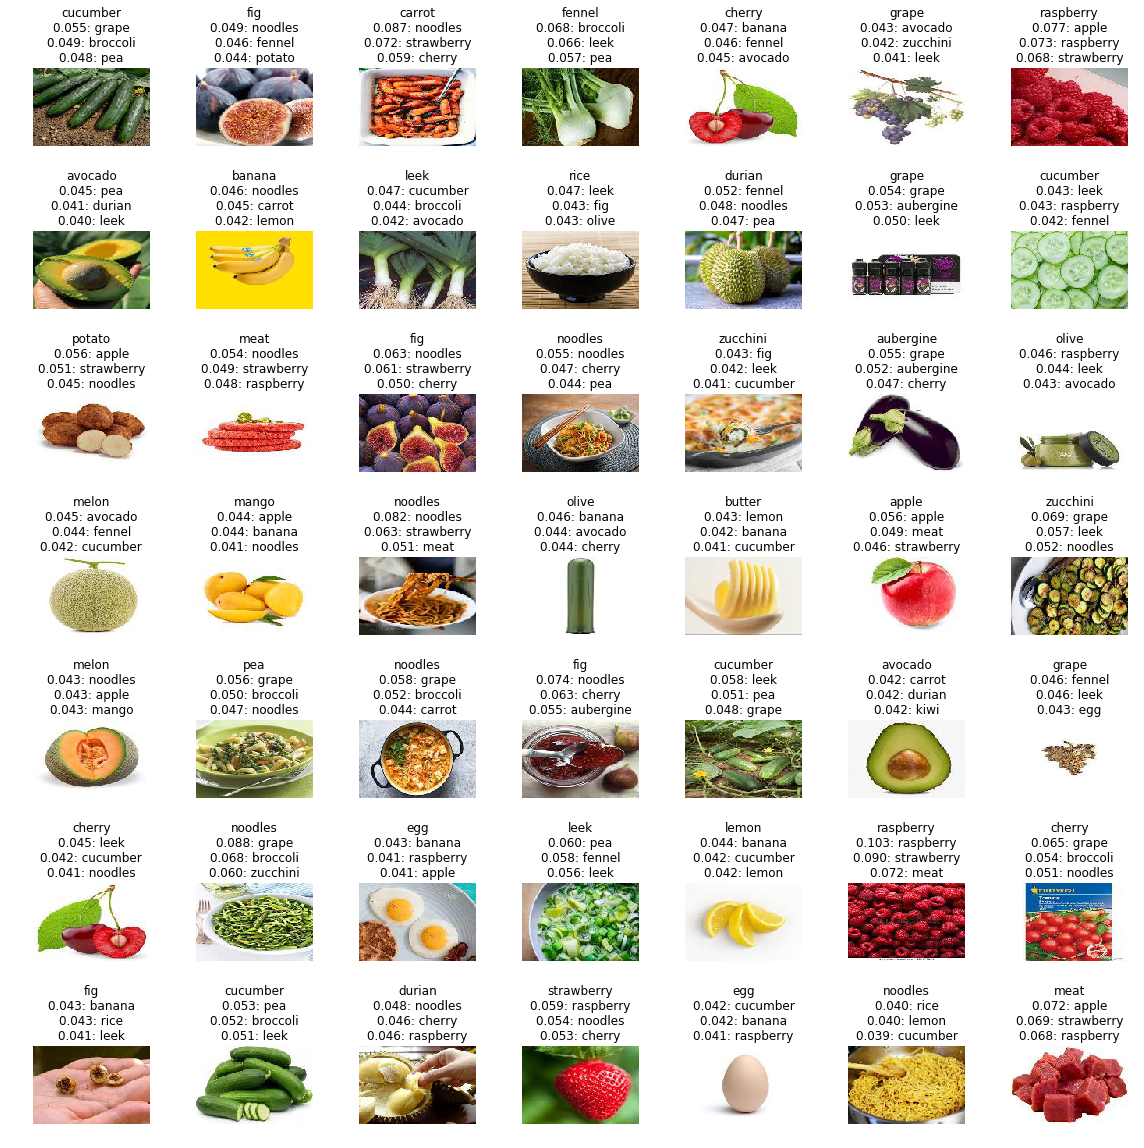

In [13]:
import matplotlib.pyplot as plt

n = 7

food_inv = {j:k for k, j in food.items()}
idx = np.random.choice(np.arange(len(X_test)), n**2, replace=False)
predictions = model.predict_proba(X_test[idx])

k = 0
f, axarr = plt.subplots(n, n, figsize=(16,16))
for i in range(0,n):
    for j in range(0,n):
        pred_classes = np.flip(predictions[k].argsort(), axis=0)[:3]
        pred_prob = predictions[k][pred_classes]
        pred_label = [food_inv[clas] for clas in pred_classes]
        title = '{}\n{:.3f}: {}\n{:.3f}: {}\n{:.3f}: {}'.format(food_inv[np.argmax(y_test[idx[k]])], pred_prob[0], pred_label[0], pred_prob[1], pred_label[1], pred_prob[2], pred_label[2])
        
        axarr[i,j].imshow(X_test[idx[k]])
        axarr[i,j].set_title(title)
        axarr[i,j].axis('off')
        k += 1
plt.tight_layout()
plt.show()

In [14]:
import pandas as pd
predictions = model.predict_classes(X_test)

df = pd.DataFrame([y_test.argmax(axis=1), predictions]).T
df.columns = ['Label', 'Prediction']
for col in ['Label', 'Prediction']:
    df[col] = df[col].apply(lambda x: food_inv[x])
df['Correct'] = df['Prediction']==df['Label']

df_group = df.groupby('Label').agg({'Prediction':'count', 'Correct':'sum'})
df_group['Ratio'] = df_group['Correct'] / df_group['Prediction']
df_group.sort_values('Ratio', ascending=False).head()

1120/1120 [==============================] - 64s    


,Prediction,Correct,Ratio
Label,,,
noodles,45,32.0,0.711111
apple,34,16.0,0.470588
leek,43,17.0,0.395349
strawberry,53,19.0,0.358491
pea,35,11.0,0.314286


In [15]:
model.load_weights('Keras_Food_Model_2.h5')

In [16]:
model.fit(X_train, y_train,
          batch_size=100,
          epochs=3,
          verbose=1,
          validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

model.save_weights('Keras_Food_Model_2.h5')

Train on 4480 samples, validate on 1120 samples
Epoch 1/3
4480/4480 [==============================] - 575s - loss: 3.2242 - acc: 0.0728 - val_loss: 3.0543 - val_acc: 0.1580
Epoch 2/3
4480/4480 [==============================] - 591s - loss: 3.1252 - acc: 0.1022 - val_loss: 2.9524 - val_acc: 0.1714
Epoch 3/3
4480/4480 [==============================] - 585s - loss: 3.0316 - acc: 0.1158 - val_loss: 2.8523 - val_acc: 0.1750
Test loss: 2.85232642719
Test accuracy: 0.175
